We're going to train on dataset B2.

In [25]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [26]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B2.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B2.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B2.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


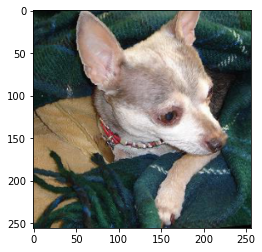

In [27]:
train_b2_img, train_b2_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b2_img.shape))
print('shape of training batch (labels): {}'.format(train_b2_label.shape))
plt.imshow(train_b2_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers, weak reg, lr decay

In [28]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [29]:
learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.9    # we'll go for a learning rate decay by a factor of 0.9 every 3 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=lr_decay)

num_epochs = 120

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 57.885863304138184
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 53.04738903045654
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 57.91858458518982
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 54.69810914993286
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 56.24480438232422
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 52.39434480667114
Current learning rate:0.001
Current training loss:3.0372352600097656
Current training accuracy:0.1611328125
Current validation loss:2.9692466259002686
Current validation accuracy:0.17499999701976776
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 50.03933358192444
Current learning rate:0.001
Current training loss:2.819363832473755
Current training accuracy:0.21484375
Cur

Current validation loss:1.9071009159088135
Current validation accuracy:0.4322916567325592
Epoch:5
Iteration:1650
Time taken for the last 50 iterations: 57.99371385574341
Current learning rate:0.0009000000000000001
Current training loss:1.6520639657974243
Current training accuracy:0.54931640625
Current validation loss:1.8145204782485962
Current validation accuracy:0.4697916805744171
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 54.99212980270386
Current learning rate:0.0008100000000000001
Current training loss:1.6521610021591187
Current training accuracy:0.51611328125
Current validation loss:1.890218734741211
Current validation accuracy:0.4468750059604645
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 55.65720200538635
Current learning rate:0.0008100000000000001
Current training loss:1.6006008386611938
Current training accuracy:0.5654296875
Current validation loss:1.8959853649139404
Current validation accuracy:0.46145832538604736
Epoch:6
Iteration:1800
Tim

Current training loss:0.7785646915435791
Current training accuracy:0.83251953125
Current validation loss:1.8019529581069946
Current validation accuracy:0.4739583432674408
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 60.74386954307556
Current learning rate:0.000729
Current training loss:0.6879134178161621
Current training accuracy:0.841796875
Current validation loss:1.8826271295547485
Current validation accuracy:0.48124998807907104
Epoch:11
Iteration:3150
Time taken for the last 50 iterations: 62.02502131462097
Current learning rate:0.000729
Current training loss:0.7448077201843262
Current training accuracy:0.826171875
Current validation loss:1.8655588626861572
Current validation accuracy:0.4854166805744171
Epoch:11
Iteration:3200
Time taken for the last 50 iterations: 63.10272455215454
Current learning rate:0.000729
Current training loss:0.6718372702598572
Current training accuracy:0.84130859375
Current validation loss:1.7943331003189087
Current validation accuracy:0.

Current validation loss:1.8379331827163696
Current validation accuracy:0.5052083134651184
Epoch:16
Iteration:4500
Time taken for the last 50 iterations: 67.09349727630615
Current learning rate:0.00059049
Current training loss:0.28799712657928467
Current training accuracy:0.9453125
Current validation loss:1.9165374040603638
Current validation accuracy:0.5104166865348816
Epoch:16
Iteration:4550
Time taken for the last 50 iterations: 65.18669700622559
Current learning rate:0.00059049
Current training loss:0.2684953808784485
Current training accuracy:0.95361328125
Current validation loss:1.9493520259857178
Current validation accuracy:0.5177083611488342
Epoch:16
Iteration:4600
Time taken for the last 50 iterations: 65.83365726470947
Current learning rate:0.00059049
Current training loss:0.3075353801250458
Current training accuracy:0.94482421875
Current validation loss:1.9062445163726807
Current validation accuracy:0.4958333373069763
Epoch:16
Iteration:4650
Time taken for the last 50 iterati

KeyboardInterrupt: 

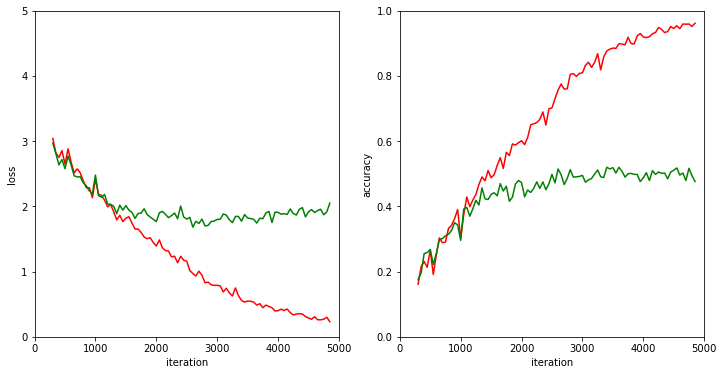

In [30]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,5000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,5000)
acc_graph.set_ylim(0,1)

plt.show() 

# Same as above, stronger lr decay

We only need to train to the point that the validation accuracy is the max (and validation loss is at a minimum). This is around 52% with a loss of around 1.67-1.71. So we'll make the lr decay stronger to reach this with a smoother learning curve.

In [31]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()

learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.7    # we'll go for a learning rate decay by a factor of 0.7 every 2 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 120

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 61.05382704734802
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 57.92205548286438
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 57.84052848815918
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 57.3736207485199
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 58.01502704620361
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 57.227232217788696
Current learning rate:0.001
Current training loss:2.9314370155334473
Current training accuracy:0.20068359375
Current validation loss:2.804804801940918
Current validation accuracy:0.21875
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 60.86989164352417
Current learning rate:0.001
Current training loss:3.031224250793457
Current training accuracy:0.16455078125
Current valid

Current validation loss:1.9169617891311646
Current validation accuracy:0.46666666865348816
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 56.90039801597595
Current learning rate:0.000343
Current training loss:1.5311380624771118
Current training accuracy:0.60107421875
Current validation loss:1.8000943660736084
Current validation accuracy:0.4947916567325592
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 63.53397059440613
Current learning rate:0.000343
Current training loss:1.5179437398910522
Current training accuracy:0.59423828125
Current validation loss:1.8528597354888916
Current validation accuracy:0.46145832538604736
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 61.98572373390198
Current learning rate:0.000343
Current training loss:1.4272801876068115
Current training accuracy:0.62744140625
Current validation loss:1.784995436668396
Current validation accuracy:0.48229166865348816
Epoch:6
Iteration:1850
Time taken for the last 50 iterations: 

Current training loss:0.7532470226287842
Current training accuracy:0.853515625
Current validation loss:1.6412311792373657
Current validation accuracy:0.5364583134651184
Epoch:11
Iteration:3150
Time taken for the last 50 iterations: 71.1699275970459
Current learning rate:0.00016806999999999998
Current training loss:0.735375165939331
Current training accuracy:0.85986328125
Current validation loss:1.661826252937317
Current validation accuracy:0.528124988079071
Epoch:11
Iteration:3200
Time taken for the last 50 iterations: 73.14265489578247
Current learning rate:0.00016806999999999998
Current training loss:0.7004035711288452
Current training accuracy:0.85986328125
Current validation loss:1.6666103601455688
Current validation accuracy:0.53125
Epoch:11
Iteration:3250
Time taken for the last 50 iterations: 71.4213650226593
Current learning rate:0.00016806999999999998
Current training loss:0.6945063471794128
Current training accuracy:0.857421875
Current validation loss:1.6379557847976685
Curre

KeyboardInterrupt: 

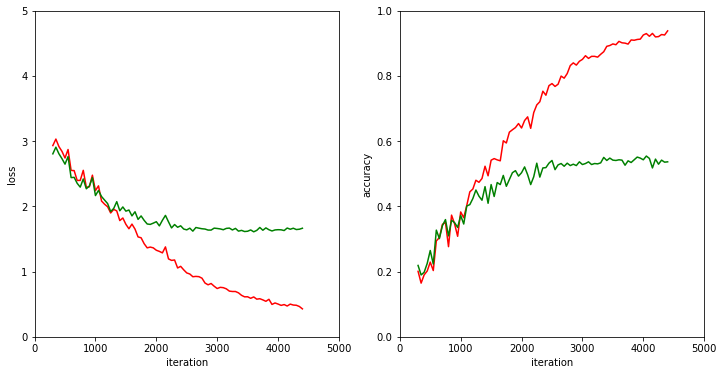

In [32]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,5000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,5000)
acc_graph.set_ylim(0,1)

plt.show() 

Need to reduce the lr decay on this one coz training is saturating around 87%

# Same as above, slightly weaker lr decay

In [33]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()

learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.75    # we'll go for a learning rate decay by a factor of 0.75 every 2 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 60

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 66.82862305641174
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 55.20119380950928
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 40.8248987197876
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 63.28559947013855
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 69.58981466293335
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 68.38468194007874
Current learning rate:0.001
Current training loss:2.9489400386810303
Current training accuracy:0.205078125
Current validation loss:2.8227505683898926
Current validation accuracy:0.23333333432674408
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 69.06382656097412
Current learning rate:0.001
Current training loss:2.933654546737671
Current training accuracy:0.18017578125
Cur

Current training loss:1.8074226379394531
Current training accuracy:0.4833984375
Current validation loss:1.9540716409683228
Current validation accuracy:0.4281249940395355
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 56.72905492782593
Current learning rate:0.00042187500000000005
Current training loss:1.5397177934646606
Current training accuracy:0.5966796875
Current validation loss:1.745567798614502
Current validation accuracy:0.47604167461395264
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 57.92217969894409
Current learning rate:0.00042187500000000005
Current training loss:1.4093430042266846
Current training accuracy:0.634765625
Current validation loss:1.7139359712600708
Current validation accuracy:0.49270832538604736
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 57.54391384124756
Current learning rate:0.00042187500000000005
Current training loss:1.4575399160385132
Current training accuracy:0.62158203125
Current validation loss:1.73136079

Current training loss:0.7292526364326477
Current training accuracy:0.85888671875
Current validation loss:1.6031066179275513
Current validation accuracy:0.5239583253860474
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 55.63663458824158
Current learning rate:0.00023730468750000005
Current training loss:0.7241345643997192
Current training accuracy:0.84814453125
Current validation loss:1.60613214969635
Current validation accuracy:0.5270833373069763
Epoch:11
Iteration:3150
Time taken for the last 50 iterations: 55.94472050666809
Current learning rate:0.00023730468750000005
Current training loss:0.6600379347801208
Current training accuracy:0.8720703125
Current validation loss:1.6037609577178955
Current validation accuracy:0.5270833373069763
Epoch:11
Iteration:3200
Time taken for the last 50 iterations: 57.60906457901001
Current learning rate:0.00023730468750000005
Current training loss:0.6547020077705383
Current training accuracy:0.88134765625
Current validation loss:1.64056

Current training loss:0.3598514199256897
Current training accuracy:0.9453125
Current validation loss:1.570120096206665
Current validation accuracy:0.5541666746139526
Epoch:16
Iteration:4500
Time taken for the last 50 iterations: 58.25591802597046
Current learning rate:0.00010011291503906251
Current training loss:0.34249362349510193
Current training accuracy:0.95654296875
Current validation loss:1.5809143781661987
Current validation accuracy:0.5583333373069763
Epoch:16
Iteration:4550
Time taken for the last 50 iterations: 57.848321199417114
Current learning rate:0.00010011291503906251
Current training loss:0.33077266812324524
Current training accuracy:0.958984375
Current validation loss:1.5954716205596924
Current validation accuracy:0.550000011920929
Epoch:16
Iteration:4600
Time taken for the last 50 iterations: 57.780012130737305
Current learning rate:0.00010011291503906251
Current training loss:0.3302915394306183
Current training accuracy:0.9541015625
Current validation loss:1.5820183

Current training loss:0.24414744973182678
Current training accuracy:0.97216796875
Current validation loss:1.6244105100631714
Current validation accuracy:0.5427083373069763
Epoch:21
Iteration:5900
Time taken for the last 50 iterations: 56.913207054138184
Current learning rate:5.631351470947266e-05
Current training loss:0.23680028319358826
Current training accuracy:0.9765625
Current validation loss:1.615297794342041
Current validation accuracy:0.5531250238418579
Epoch:21
Iteration:5950
Time taken for the last 50 iterations: 57.92383694648743
Current learning rate:5.631351470947266e-05
Current training loss:0.23236428201198578
Current training accuracy:0.97607421875
Current validation loss:1.631204605102539
Current validation accuracy:0.5458333492279053
Epoch:21
Iteration:6000
Time taken for the last 50 iterations: 58.06023097038269
Current learning rate:5.631351470947266e-05
Current training loss:0.2198912650346756
Current training accuracy:0.9775390625
Current validation loss:1.62349271

Current training loss:0.17676939070224762
Current training accuracy:0.978515625
Current validation loss:1.6269476413726807
Current validation accuracy:0.5562499761581421
Epoch:26
Iteration:7300
Time taken for the last 50 iterations: 57.786452770233154
Current learning rate:2.3757264018058778e-05
Current training loss:0.19596301019191742
Current training accuracy:0.978515625
Current validation loss:1.6363056898117065
Current validation accuracy:0.5635416507720947
Epoch:26
Iteration:7350
Time taken for the last 50 iterations: 57.89882779121399
Current learning rate:2.3757264018058778e-05
Current training loss:0.19023683667182922
Current training accuracy:0.97998046875
Current validation loss:1.6380460262298584
Current validation accuracy:0.5625
Epoch:26
Iteration:7400
Time taken for the last 50 iterations: 57.21574807167053
Current learning rate:2.3757264018058778e-05
Current training loss:0.18286611139774323
Current training accuracy:0.98095703125
Current validation loss:1.6275547742843

Current training loss:0.17319762706756592
Current training accuracy:0.982421875
Current validation loss:1.6422172784805298
Current validation accuracy:0.5604166388511658
Epoch:31
Iteration:8700
Time taken for the last 50 iterations: 56.26292634010315
Current learning rate:1.3363461010158061e-05
Current training loss:0.15594156086444855
Current training accuracy:0.98486328125
Current validation loss:1.6349685192108154
Current validation accuracy:0.5541666746139526
Epoch:31
Iteration:8750
Time taken for the last 50 iterations: 57.82946968078613
Current learning rate:1.3363461010158061e-05
Current training loss:0.17216022312641144
Current training accuracy:0.9833984375
Current validation loss:1.639443278312683
Current validation accuracy:0.5572916865348816
Epoch:31
Iteration:8800
Time taken for the last 50 iterations: 57.019418716430664
Current learning rate:1.3363461010158061e-05
Current training loss:0.1493837535381317
Current training accuracy:0.98388671875
Current validation loss:1.64

Current training loss:0.16116014122962952
Current training accuracy:0.9833984375
Current validation loss:1.6487408876419067
Current validation accuracy:0.5552083253860474
Epoch:36
Iteration:10100
Time taken for the last 50 iterations: 55.17179250717163
Current learning rate:5.637710113660432e-06
Current training loss:0.15648886561393738
Current training accuracy:0.9833984375
Current validation loss:1.6484912633895874
Current validation accuracy:0.559374988079071
Epoch:36
Iteration:10150
Time taken for the last 50 iterations: 54.23459339141846
Current learning rate:5.637710113660432e-06
Current training loss:0.15966962277889252
Current training accuracy:0.9833984375
Current validation loss:1.6459333896636963
Current validation accuracy:0.5531250238418579
Epoch:36
Iteration:10200
Time taken for the last 50 iterations: 57.38072896003723
Current learning rate:5.637710113660432e-06
Current training loss:0.15891419351100922
Current training accuracy:0.98291015625
Current validation loss:1.64

Current training loss:0.14008863270282745
Current training accuracy:0.98828125
Current validation loss:1.6477402448654175
Current validation accuracy:0.5541666746139526
Epoch:41
Iteration:11500
Time taken for the last 50 iterations: 56.74321126937866
Current learning rate:3.171211938933993e-06
Current training loss:0.14189794659614563
Current training accuracy:0.9853515625
Current validation loss:1.6528944969177246
Current validation accuracy:0.5552083253860474
Epoch:41
Iteration:11550
Time taken for the last 50 iterations: 58.7413444519043
Current learning rate:3.171211938933993e-06
Current training loss:0.1677713245153427
Current training accuracy:0.984375
Current validation loss:1.652028203010559
Current validation accuracy:0.5510416626930237
Epoch:42
Iteration:11600
Time taken for the last 50 iterations: 57.7279098033905
Current learning rate:2.3784089542004944e-06
Current training loss:0.16411252319812775
Current training accuracy:0.98095703125
Current validation loss:1.6468864679

Epoch:46
Iteration:12850
Time taken for the last 50 iterations: 57.27249026298523
Current learning rate:1.337855036737778e-06
Current training loss:0.17270265519618988
Current training accuracy:0.98291015625
Current validation loss:1.644894003868103
Current validation accuracy:0.5520833134651184
Epoch:46
Iteration:12900
Time taken for the last 50 iterations: 57.42993783950806
Current learning rate:1.337855036737778e-06
Current training loss:0.14330151677131653
Current training accuracy:0.9853515625
Current validation loss:1.6484284400939941
Current validation accuracy:0.5583333373069763
Epoch:46
Iteration:12950
Time taken for the last 50 iterations: 57.67747688293457
Current learning rate:1.337855036737778e-06
Current training loss:0.15381751954555511
Current training accuracy:0.986328125
Current validation loss:1.6519582271575928
Current validation accuracy:0.5510416626930237
Epoch:47
Iteration:13000
Time taken for the last 50 iterations: 56.80961322784424
Current learning rate:1.3378

Current validation loss:1.653916835784912
Current validation accuracy:0.5541666746139526
Epoch:51
Iteration:14250
Time taken for the last 50 iterations: 57.88994121551514
Current learning rate:7.525434581650002e-07
Current training loss:0.14193227887153625
Current training accuracy:0.98681640625
Current validation loss:1.6494511365890503
Current validation accuracy:0.5572916865348816
Epoch:51
Iteration:14300
Time taken for the last 50 iterations: 57.1774697303772
Current learning rate:7.525434581650002e-07
Current training loss:0.15473312139511108
Current training accuracy:0.9833984375
Current validation loss:1.650457739830017
Current validation accuracy:0.5520833134651184
Epoch:51
Iteration:14350
Time taken for the last 50 iterations: 56.196205854415894
Current learning rate:7.525434581650002e-07
Current training loss:0.17345432937145233
Current training accuracy:0.97998046875
Current validation loss:1.6594613790512085
Current validation accuracy:0.559374988079071
Epoch:52
Iteration:1

Current training loss:0.1379913091659546
Current training accuracy:0.9912109375
Current validation loss:1.6554691791534424
Current validation accuracy:0.5562499761581421
Epoch:56
Iteration:15650
Time taken for the last 50 iterations: 57.40940713882446
Current learning rate:3.1747927141335945e-07
Current training loss:0.15267270803451538
Current training accuracy:0.9853515625
Current validation loss:1.6440455913543701
Current validation accuracy:0.5625
Epoch:56
Iteration:15700
Time taken for the last 50 iterations: 55.23220157623291
Current learning rate:3.1747927141335945e-07
Current training loss:0.1552000641822815
Current training accuracy:0.9853515625
Current validation loss:1.6620819568634033
Current validation accuracy:0.5562499761581421
Epoch:57
Iteration:15750
Time taken for the last 50 iterations: 57.00573229789734
Current learning rate:3.1747927141335945e-07
Current training loss:0.14452262222766876
Current training accuracy:0.98681640625
Current validation loss:1.651021838188

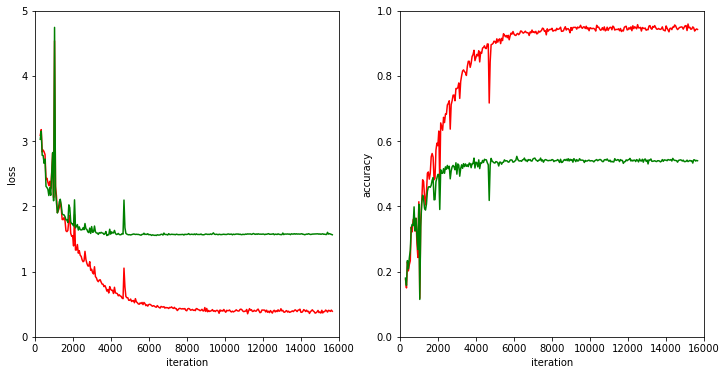

In [14]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,16000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,16000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 5 conv layers

In [34]:
class PetCNN5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=2, stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

loss_function = nn.NLLLoss()


model1 = PetCNN5()
print(model1)



PetCNN5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(128

In [35]:
learning_rate = 0.001
decay_rate = 0.0002
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 12.464475393295288
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 12.641777276992798
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 12.53882384300232
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 12.54911732673645
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 12.642948627471924
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 12.55240249633789
Current training loss:3.290499448776245
Current training accuracy:0.095703125
Current validation loss:3.2116737365722656
Current validation accuracy:0.11874999850988388
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 12.604524374008179
Current training loss:3.1523849964141846
Current training accuracy:0.1298828125
Current validation loss:3.027052640914917
Current validation accuracy:0.15000000596046448
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 12.581177234649658
Current training loss:3.1

Current training loss:2.5387017726898193
Current training accuracy:0.2705078125
Current validation loss:2.5380988121032715
Current validation accuracy:0.2666666805744171
Epoch:6
Iteration:1900
Time taken for the last 50 iterations: 13.456810235977173
Current training loss:2.4040496349334717
Current training accuracy:0.328125
Current validation loss:2.4395668506622314
Current validation accuracy:0.296875
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 12.826483249664307
Current training loss:2.4455995559692383
Current training accuracy:0.302734375
Current validation loss:2.43532395362854
Current validation accuracy:0.29374998807907104
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 13.756819486618042
Current training loss:2.5558314323425293
Current training accuracy:0.283203125
Current validation loss:2.5871036052703857
Current validation accuracy:0.2645833194255829
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 13.393593072891235
Current train

Current training loss:1.9415769577026367
Current training accuracy:0.443359375
Current validation loss:2.2047054767608643
Current validation accuracy:0.37187498807907104
Epoch:12
Iteration:3550
Time taken for the last 50 iterations: 12.920135498046875
Current training loss:1.9817885160446167
Current training accuracy:0.42822265625
Current validation loss:2.323761224746704
Current validation accuracy:0.3447916805744171
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 12.538838386535645
Current training loss:1.9135873317718506
Current training accuracy:0.458984375
Current validation loss:2.2526001930236816
Current validation accuracy:0.36250001192092896
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 12.814291954040527
Current training loss:1.918738842010498
Current training accuracy:0.45654296875
Current validation loss:2.234165906906128
Current validation accuracy:0.35624998807907104
Epoch:13
Iteration:3700
Time taken for the last 50 iterations: 12.88947010

Epoch:18
Iteration:5150
Time taken for the last 50 iterations: 12.662623882293701
Current training loss:1.4600131511688232
Current training accuracy:0.6005859375
Current validation loss:2.2487287521362305
Current validation accuracy:0.3656249940395355
Epoch:18
Iteration:5200
Time taken for the last 50 iterations: 12.944320678710938
Current training loss:1.4568055868148804
Current training accuracy:0.59326171875
Current validation loss:2.239619493484497
Current validation accuracy:0.3583333194255829
Epoch:19
Iteration:5250
Time taken for the last 50 iterations: 12.729491472244263
Current training loss:1.4744794368743896
Current training accuracy:0.58154296875
Current validation loss:2.2774741649627686
Current validation accuracy:0.3552083373069763
Epoch:19
Iteration:5300
Time taken for the last 50 iterations: 12.852742671966553
Current training loss:1.471735954284668
Current training accuracy:0.5830078125
Current validation loss:2.3509914875030518
Current validation accuracy:0.337500005

Current validation loss:2.3422725200653076
Current validation accuracy:0.36145833134651184
Epoch:24
Iteration:6800
Time taken for the last 50 iterations: 12.691803932189941
Current training loss:1.104949712753296
Current training accuracy:0.7109375
Current validation loss:2.3917107582092285
Current validation accuracy:0.34687501192092896
Epoch:24
Iteration:6850
Time taken for the last 50 iterations: 12.868371725082397
Current training loss:1.1825939416885376
Current training accuracy:0.69384765625
Current validation loss:2.3741912841796875
Current validation accuracy:0.35104167461395264
Epoch:24
Iteration:6900
Time taken for the last 50 iterations: 12.750038862228394
Current training loss:1.0612813234329224
Current training accuracy:0.7265625
Current validation loss:2.3469274044036865
Current validation accuracy:0.3604166805744171
Epoch:25
Iteration:6950
Time taken for the last 50 iterations: 12.843741178512573
Current training loss:1.0943803787231445
Current training accuracy:0.714843

KeyboardInterrupt: 

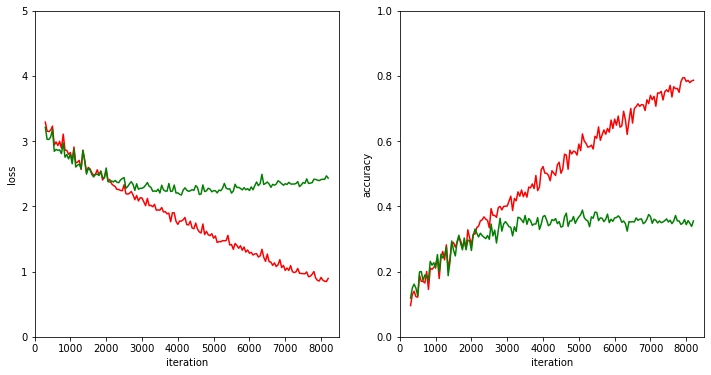

In [36]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,8500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,8500)
acc_graph.set_ylim(0,1)

plt.show() 

This starts overfitting at around 36% validation accuracy. We'll stick to the 6 conv layers.